In [1]:
!pip install timm # torch image models library

     |████████████████████████████████| 245kB 13.4MB/s 


In [2]:
import torch
import timm
import tqdm
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
torch.cuda.get_device_name()

'Tesla T4'

In [4]:
timm.list_models("vit*")

['vit_base_patch16_224',
 'vit_base_patch16_384',
 'vit_base_patch32_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50d_224',
 'vit_huge_patch16_224',
 'vit_huge_patch32_384',
 'vit_large_patch16_224',
 'vit_large_patch16_384',
 'vit_large_patch32_384',
 'vit_small_patch16_224',
 'vit_small_resnet26d_224',
 'vit_small_resnet50d_s3_224']

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model = "vit_base_patch16_224"
img_size = 224
epochs = 5
batch_size = 100
lr = 1e-3

In [6]:
device

device(type='cuda')

In [7]:
class_dict = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 
              5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

In [8]:
transform = transforms.Compose([transforms.Resize((img_size, img_size)), 
                                transforms.ToTensor(), 
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [9]:
train_data = datasets.CIFAR10("data/", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10("data/", train=False, download=True, transform=transform)

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [10]:
train_batches = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_batches = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [11]:
len(train_batches), len(test_batches)

(500, 100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x7f63400557f0>, 2)

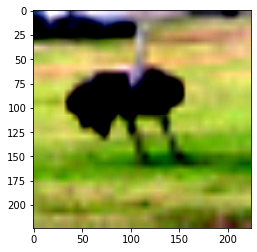

In [12]:
img, label = train_data[42]
plt.imshow(img.permute(1, 2, 0)), label

In [13]:
net = timm.create_model(pretrained_model, pretrained=True)

for param in net.parameters():
    param.requires_grad = False

net.head = nn.Linear(net.head.in_features, 10)
net.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

In [14]:
num_parameters = sum(p.numel() for p in net.parameters() if p.requires_grad)
num_parameters

7690

In [15]:
opt = torch.optim.Adam(net.parameters(), lr)
loss_fn = nn.CrossEntropyLoss()

In [16]:
input = torch.randn(100, 3, 224, 224).to(device)
output = net(input)
output.shape

torch.Size([100, 10])

In [17]:
def get_accuracy(preds, y):
    preds = preds.argmax(dim=1, keepdim=True)
    correct = preds.squeeze(1).eq(y)
    acc = correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)

    return acc.item()

In [18]:
def loop(net, batches, train):
    batch_losses = []
    batch_accs = []

    if train:
        print("Train Loop:")
        print("")
        net.train()

        for X, y in tqdm.tqdm(batches, total=len(batches)):
            X = X.to(device)
            y = y.to(device)

            preds = net(X)
            loss = loss_fn(preds, y)
            acc = get_accuracy(preds, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            batch_losses.append(loss.item())
            batch_accs.append(acc)

    else:
        print("Validation Loop:")
        print("")
        net.eval()

        with torch.no_grad():
            for X, y in tqdm.tqdm(batches, total=len(batches)):
                X = X.to(device)
                y = y.to(device)

                preds = net(X)
                loss = loss_fn(preds, y)
                acc = get_accuracy(preds, y)

                batch_losses.append(loss.item())
                batch_accs.append(acc) 

    print("")
    print("")
    
    return sum(batch_losses) / len(batch_losses), sum(batch_accs) / len(batch_accs)

In [19]:
def predict(net, img, transform, class_dict):
    img = Image.open(img).convert("RGB")
    img = transform(img).to(device)
    net.eval()

    with torch.no_grad():
        pred = net(img.unsqueeze(0))
    
    pred = pred.argmax(dim=1)
    print(class_dict[pred.item()])

In [20]:
for epoch in range(epochs):
    train_loss, train_acc = loop(net, train_batches, True)
    val_loss, val_acc = loop(net, test_batches, False)
    
    print(f"epoch: {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")
    print("")

  0%|          | 0/500 [00:00<?, ?it/s]

Train Loop:



  0%|          | 0/100 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/500 [00:00<?, ?it/s]



epoch: 0 | train_loss: 0.2887 | train_acc: 0.9110 | val_loss: 0.2095 | val_acc: 0.9329

Train Loop:



  0%|          | 0/100 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/500 [00:00<?, ?it/s]



epoch: 1 | train_loss: 0.1859 | train_acc: 0.9389 | val_loss: 0.1976 | val_acc: 0.9363

Train Loop:



  0%|          | 0/100 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/500 [00:00<?, ?it/s]



epoch: 2 | train_loss: 0.1654 | train_acc: 0.9444 | val_loss: 0.1934 | val_acc: 0.9350

Train Loop:



  0%|          | 0/100 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/500 [00:00<?, ?it/s]



epoch: 3 | train_loss: 0.1537 | train_acc: 0.9479 | val_loss: 0.1946 | val_acc: 0.9366

Train Loop:



  0%|          | 0/100 [00:00<?, ?it/s]



Validation Loop:



100%|██████████| 100/100 [02:21<00:00,  1.42s/it]



epoch: 4 | train_loss: 0.1453 | train_acc: 0.9511 | val_loss: 0.1974 | val_acc: 0.9349



In [21]:
predict(net, "test_images/horse.png", transform, class_dict)

horse


In [25]:
predict(net, "test_images/dog.jpg", transform, class_dict)

dog


In [24]:
predict(net, "test_images/bird.jpg", transform, class_dict)

bird
